In [1]:
# 딥러닝 응용
# 이미지분류 , 오토인코더, 전이학습, 자연어처리, 시계열 분석

In [2]:
# Fashion MNIST  - CNN  28x28   10가지 클래스

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random

In [4]:
# 랜럼시드 고정
SEED = 12
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
# 데이콘에 있는 데이터를 가져온다.
drive_path = './FM/data/'
train = pd.read_csv(drive_path+'train.csv')
test = pd.read_csv(drive_path+'test.csv')
submission = pd.read_csv(drive_path+'sample_submission.csv')
train.shape, test.shape, submission.shape

((60000, 786), (10000, 785), (10000, 2))

In [6]:
28*28

784

In [7]:
train.head()

,index,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,6,0,0,0,0,0,0,0,5,...,0,0,0,30,43,0,0,0,0,0
3,3,0,0,0,0,1,2,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
train.loc[:,'pixel1':].values.min(), train.loc[:,'pixel1':].values.max()  # 0 ~ 255
x_train = train.loc[:,'pixel1':]
y_train = train.loc[:,'label']

In [9]:
# 주어진 데이터는 784개의 1차원 벡터
# 이미지로 표현  28*28 2차원 벡터
train_images =  x_train.values.reshape(-1,28,28)
train_images.shape

(60000, 28, 28)

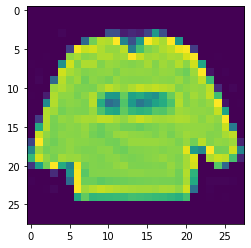

In [10]:
# 첫번째 이미지 출력
import matplotlib.pyplot as plt
plt.imshow(train_images[0])
plt.show()

In [11]:
train['label'].value_counts() # 0 ~ 9

2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: label, dtype: int64

In [12]:
target_value = {
0 : 'T-shirt/top',
1 : 'Trouser',
2 : 'Pullover',
3 : 'Dress',
4 : 'Coat',
5 : 'Sandal',
6 : 'Shirt',
7 : 'Sneaker',
8 : 'Bag',
9 : 'Ankle boot'
}

In [13]:
target_value[9]

'Ankle boot'

In [14]:
test.head()

,index,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
test_images =  test.loc[:,'pixel1':].values.reshape(-1,28,28)
test_images.shape

(10000, 28, 28)

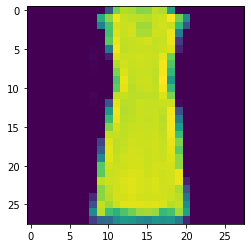

In [16]:
plt.imshow(test_images[499])

In [17]:
#  스케일 맞추기
x_train =  train_images / 255
x_test = test_images / 255
x_train.min(), x_train.max(), x_test.min(), x_test.max()

(0.0, 1.0, 0.0, 1.0)

In [18]:
# 합성곱 CNN은 RGB의 채널값을 입력받은 것을 전재로 설계  3차원
x_train.shape

(60000, 28, 28)

In [19]:
x_train = x_train.reshape(60000,28,28,-1)
x_train.shape

(60000, 28, 28, 1)

In [20]:
x_test = np.expand_dims(x_test,axis=-1)
x_test.shape

(10000, 28, 28, 1)

In [21]:
# # 데이터 분할.... 교차검증도 고려해서  0.2
# stratify 옵션은 정답의 빈도수를 적절하게 섞어서. 
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(x_train, y_train, test_size = 0.2, stratify=y_train,random_state=42)

In [23]:
print("학습 데이터셋 크기:",x_tr.shape, y_tr.shape)
print("검증 데이터셋 크기:",x_val.shape, y_val.shape)

학습 데이터셋 크기: (48000, 28, 28, 1) (48000,)
검증 데이터셋 크기: (12000, 28, 28, 1) (12000,)


In [24]:
# 모델학습
# Flatten 레이어 : 가로세로의 형태의 이미지를 1차원 배열로 변경
# Dense : 2   출력은 10(정답이 10)  
# 활성화 함수는 다중분류 - softmax

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape = [28,28]))
mlp_model.add(Dense(units=64, activation='relu'))
mlp_model.add(Dense(units=10, activation='softmax'))
mlp_model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['acc'])
mlp_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                50240     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [34]:
mlp_history =  mlp_model.fit(x_tr,y_tr, batch_size=64, epochs=50, validation_data=(x_val, y_val), verbose=1)

Epoch 1/50
750/750 [==============================] - 1s 2ms/step - loss: 0.5791 - acc: 0.8013 - val_loss: 0.5204 - val_acc: 0.8023
Epoch 2/50
750/750 [==============================] - 1s 1ms/step - loss: 0.4305 - acc: 0.8487 - val_loss: 0.4075 - val_acc: 0.8545
Epoch 3/50
750/750 [==============================] - 1s 1ms/step - loss: 0.3851 - acc: 0.8629 - val_loss: 0.3743 - val_acc: 0.8622
Epoch 4/50
750/750 [==============================] - 1s 1ms/step - loss: 0.3590 - acc: 0.8728 - val_loss: 0.3724 - val_acc: 0.8607
Epoch 5/50
750/750 [==============================] - 1s 1ms/step - loss: 0.3417 - acc: 0.8785 - val_loss: 0.3588 - val_acc: 0.8685
Epoch 6/50
750/750 [==============================] - 1s 1ms/step - loss: 0.3277 - acc: 0.8838 - val_loss: 0.3470 - val_acc: 0.8719
Epoch 7/50
750/750 [==============================] - 1s 1ms/step - loss: 0.3174 - acc: 0.8850 - val_loss: 0.3471 - val_acc: 0.8702
Epoch 8/50
750/750 [==============================] - 1s 1ms/step - loss: 0.

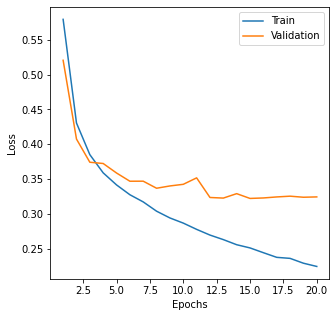

In [39]:
# 손실함수
def plot_loss_curve(history, total_epoch=10, start=1):
    plt.figure(figsize=(5,5))
    plt.plot(range(start,total_epoch+1),  history.history['loss'][start-1:total_epoch],
             label="Train"
            )
    plt.plot(range(start, total_epoch+1), history.history['val_loss'][start-1:total_epoch],
             label = 'Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss_curve(history=mlp_history,total_epoch=20,start=1)       
    

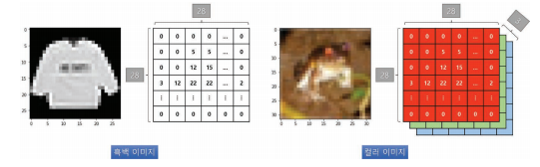

In [42]:
# 합성곱 신경망.
# 이미지에 합성곱(convolution) 필터(filter , kernel)을 적용하여 시각적 특징을 추출하는 딥러닝 알고리즘
# https://raw.githubusercontent.com/bigdataleeky/python/main/image2/01.PNG
from IPython.display import Image
Image("https://raw.githubusercontent.com/bigdataleeky/python/main/image2/01.PNG",width = 300)

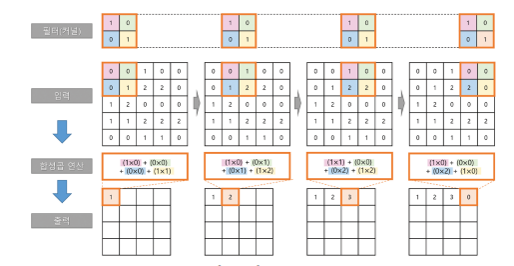

In [44]:
# 5 x 5  크기의 이미지 데이터에 2 x 2 크기의 필터를 적용하는 합성곱 과정
Image("https://raw.githubusercontent.com/bigdataleeky/python/main/image2/02.PNG")

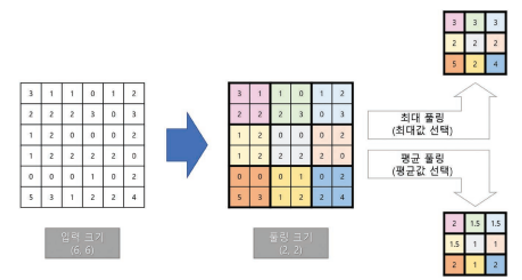

In [45]:
# 폴링(pooling) 폴링크기로 입력 이미지를 겹치지 않게 나누고 각 구역에서 최대 값 또는 평균값을 계산하는 방식
# 이미지의 크기를 줄인다.
Image("https://raw.githubusercontent.com/bigdataleeky/python/main/image2/03.PNG")

In [46]:
# 합성곱 연산은 Conv2D - MaxPooling2D 레이어를 연결  --> 입력이미지의 특징을 추출

In [50]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# CNN
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu', input_shape=[28,28,1]))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
# 완전연결 신경망
cnn_model.add(Flatten())                            # 1차원으로 변경
cnn_model.add(Dense(units=64,activation='relu'))    # hidden layer
cnn_model.add(Dense(units=10,activation='softmax'))  # 출력층

cnn_model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy',metrics=['acc'])

cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 2704)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                173120    
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 173,930
Trainable params: 173,930
Non-trainable params: 0
________________________________________________

In [53]:
cnn_history = cnn_model.fit(x_tr,y_tr,batch_size=64,epochs=20, validation_data=(x_val,y_val),verbose=1)

Epoch 1/20
750/750 [==============================] - 6s 9ms/step - loss: 0.2316 - acc: 0.9169 - val_loss: 0.2782 - val_acc: 0.9007
Epoch 2/20
750/750 [==============================] - 6s 9ms/step - loss: 0.2159 - acc: 0.9220 - val_loss: 0.2607 - val_acc: 0.9059
Epoch 3/20
750/750 [==============================] - 6s 8ms/step - loss: 0.1998 - acc: 0.9280 - val_loss: 0.2605 - val_acc: 0.9065
Epoch 4/20
750/750 [==============================] - 6s 8ms/step - loss: 0.1866 - acc: 0.9326 - val_loss: 0.2563 - val_acc: 0.9082
Epoch 5/20
750/750 [==============================] - 6s 8ms/step - loss: 0.1716 - acc: 0.9377 - val_loss: 0.2594 - val_acc: 0.9097
Epoch 6/20
750/750 [==============================] - 7s 9ms/step - loss: 0.1602 - acc: 0.9424 - val_loss: 0.2563 - val_acc: 0.9099
Epoch 7/20
750/750 [==============================] - 6s 9ms/step - loss: 0.1488 - acc: 0.9470 - val_loss: 0.2690 - val_acc: 0.9043
Epoch 8/20
750/750 [==============================] - 7s 9ms/step - loss: 0.

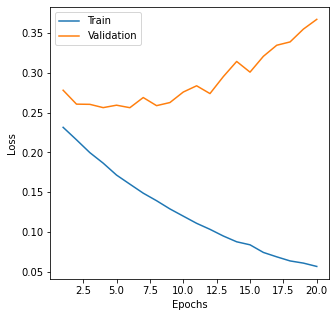

In [54]:
plot_loss_curve(history=cnn_history,total_epoch=20,start=1)

In [55]:
# 과대적합 방지
from tensorflow.keras.layers import Dropout
def build_cnn():
    model = Sequential()
    model.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu', input_shape=[28,28,1]))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())                            # 1차원으로 변경
    model.add(Dense(units=64,activation='relu'))    # hidden layer
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=10,activation='softmax'))  # 출력층
    model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy',metrics=['acc'])
    return model

cnn_model = build_cnn()
cnn_model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 2704)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                173120    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 10)                650       
                                                      

In [56]:
# 추가로 Early Stopping 콜백
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience=10)
cnn_history = cnn_model.fit(x_tr, y_tr, batch_size=64, epochs=100, validation_data=(x_val,y_val)
                           ,callbacks=[early_stopping],verbose = 1)

Epoch 1/100
750/750 [==============================] - 7s 9ms/step - loss: 0.6788 - acc: 0.7653 - val_loss: 0.3870 - val_acc: 0.8616
Epoch 2/100
750/750 [==============================] - 7s 9ms/step - loss: 0.4515 - acc: 0.8440 - val_loss: 0.3379 - val_acc: 0.8751
Epoch 3/100
750/750 [==============================] - 7s 9ms/step - loss: 0.3959 - acc: 0.8611 - val_loss: 0.3029 - val_acc: 0.8877
Epoch 4/100
750/750 [==============================] - 7s 9ms/step - loss: 0.3666 - acc: 0.8708 - val_loss: 0.2867 - val_acc: 0.8953
Epoch 5/100
750/750 [==============================] - 7s 9ms/step - loss: 0.3432 - acc: 0.8788 - val_loss: 0.2818 - val_acc: 0.8966
Epoch 6/100
750/750 [==============================] - 7s 10ms/step - loss: 0.3304 - acc: 0.8817 - val_loss: 0.2772 - val_acc: 0.8988
Epoch 7/100
750/750 [==============================] - 7s 9ms/step - loss: 0.3171 - acc: 0.8877 - val_loss: 0.2776 - val_acc: 0.8959
Epoch 8/100
750/750 [==============================] - 7s 10ms/step 

In [57]:
cnn_model.save("./cnn_model_fashionMNIST.h5")

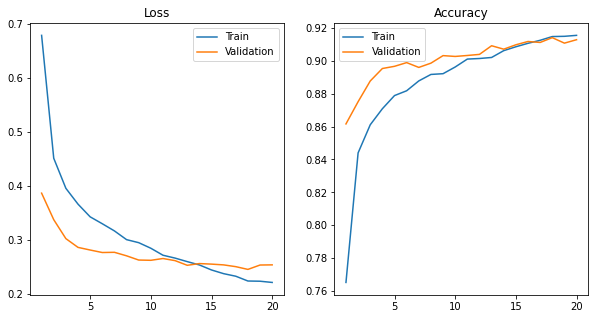

In [59]:
# 손실(loss) 그래프  정확도(accuracy) 그래프
start =1 
end = 20
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(start,end+1),cnn_history.history['loss'][start-1:end], label='Train')
axes[0].plot(range(start,end+1),cnn_history.history['val_loss'][start-1:end], label='Validation')
axes[0].set_title("Loss")
axes[0].legend()


axes[1].plot(range(start,end+1),cnn_history.history['acc'][start-1:end], label='Train')
axes[1].plot(range(start,end+1),cnn_history.history['val_acc'][start-1:end], label='Validation')
axes[1].set_title("Accuracy")
axes[1].legend()

plt.show()

In [60]:
cnn_model.evaluate(x_val,y_val)

375/375 [==============================] - 1s 2ms/step - loss: 0.2622 - acc: 0.9139


[0.262200266122818, 0.9139166474342346]

In [61]:
y_pred_proba =  cnn_model.predict(x_test)
y_pred_classes =  np.argmax(y_pred_proba, axis=-1)

313/313 [==============================] - 1s 2ms/step


In [63]:
y_pred_classes[:6]

array([0, 1, 2, 6, 3, 6], dtype=int64)

In [64]:
# Dacon에 제출
submission['label'] = y_pred_classes
submission_filepath = drive_path+'mnist_cnn_submission1.csv'
submission.to_csv(submission_filepath,index=False)

In [78]:
# 사용자 정의 콜백함수
#  검증정확도(val_acc)점수가 0.90보다 클 경우 학습을 조기 종료
# ModelCheckpoint 콜백 함수를 이용하면 모델을 저장

In [79]:
from tensorflow.keras.callbacks import Callback
class my_callBack(Callback): #Callback 상속
    def on_epoch_end(self,epoch, logs = {}):
        if(logs.get('val_acc') > 0.90):
            self.model.stop_training = True
            print("\n")
            print(f"목표정확도 달성: 검증정확도 {logs.get('val_acc')}")

#객체 생성            
my_callback = my_callBack();            
#best model저장
from tensorflow.keras.callbacks import ModelCheckpoint
best_model_path = drive_path+'best_cnn_model.h5'
save_best_model = ModelCheckpoint(best_model_path,monitor='val_loss', save_beset_only=True,
                                 save_weights_only=False)
    

In [80]:
# cnn 모델 학습
cnn_model = build_cnn()
cnn_history = cnn_model.fit(x_tr,y_tr,batch_size=64, epochs=100, validation_data=(x_val,y_val),
                            callbacks=[my_callback,save_best_model],verbose=1)

Epoch 1/100
750/750 [==============================] - 7s 9ms/step - loss: 0.6833 - acc: 0.7616 - val_loss: 0.3877 - val_acc: 0.8591
Epoch 2/100
750/750 [==============================] - 7s 9ms/step - loss: 0.4482 - acc: 0.8442 - val_loss: 0.3354 - val_acc: 0.8774
Epoch 3/100
750/750 [==============================] - 7s 9ms/step - loss: 0.3978 - acc: 0.8593 - val_loss: 0.3029 - val_acc: 0.8890
Epoch 4/100
750/750 [==============================] - 6s 9ms/step - loss: 0.3710 - acc: 0.8705 - val_loss: 0.2894 - val_acc: 0.8955
Epoch 5/100
750/750 [==============================] - 6s 9ms/step - loss: 0.3473 - acc: 0.8781 - val_loss: 0.2794 - val_acc: 0.8991
Epoch 6/100
749/750 [============================>.] - ETA: 0s - loss: 0.3303 - acc: 0.8829

목표정확도 달성: 검증정확도 0.9005833268165588
750/750 [==============================] - 6s 8ms/step - loss: 0.3302 - acc: 0.8830 - val_loss: 0.2754 - val_acc: 0.9006


In [81]:
print("학습종료")

학습종료


In [82]:
# 저장된 모델을 불러오기
from tensorflow.keras.models import load_model
best_model = load_model(drive_path+'best_cnn_model.h5')
best_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 2704)              0         
                                                                 
 dense_10 (Dense)            (None, 64)                173120    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                      

In [84]:
# Dacon에 제출
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=-1)
submission['label'] = y_pred_classes
submission_filepath = drive_path+'mnist_cnn_submission2.csv'
submission.to_csv(submission_filepath,index=False)

313/313 [==============================] - 1s 2ms/step
